In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

# 1 Data

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
from tqdm import tqdm_notebook as tqdm

import sklearn
from sklearn.model_selection import StratifiedKFold

In [3]:
face_path = '../../dataset/PINS'
people_list = os.listdir(face_path)
display(len(people_list), people_list[:5])

person2index = {person:i for i, person in enumerate(people_list)}
index2person = {i:person for i, person in enumerate(people_list)}

person_path = os.path.join(face_path, people_list[0])
person_img_list = os.listdir(person_path)
display(person_img_list[:5])

# 建立一个dataframe，用来建立数据到标签的关系，方便建立dataset
# 其实使用fastai的from_folder更快的建立databunch，但是这里为了锻炼能力起见，我决定使用原始的方法来构建dataset
# create the dataframe
person_df = pd.DataFrame()
for person in tqdm(os.listdir(face_path)):
    person_imgs_path = os.path.join(face_path, person)
    for img in os.listdir(person_imgs_path):
        img_file_path = os.path.join(person_imgs_path, img)
        label = person
        dict_person = {'path':img_file_path, 'label':label}
        person_df = person_df.append(pd.Series(dict_person), ignore_index=True)

100

['pins_maria pedraza',
 'pins_margot robbie face',
 'pins_Chris Evans',
 'pins_millie bobby brown',
 'pins_Cobie Smulders']

['maria pedraza108_1614.jpg',
 'maria pedraza71_1622.jpg',
 'maria pedraza168_1581.jpg',
 'maria pedraza68_1618.jpg',
 'maria pedraza60_1619.jpg']

HBox(children=(IntProgress(value=0), HTML(value='')))

In [4]:
# 划分数据集，采用sklearn的StratifiedKFold来做处理
# 推理三大邪招：TTA、Pseudo Label、Ensemble
# 我不想用，只有快速的算法才有意义.于是乎，我就掉入了SqueezeNet、MobileNet和ShuffleNet、IGCV的网兜里。

display(person_df.head(), f'the length of data is {len(person_df)}')
 
x, y = person_df['path'], person_df['label']

n_splits = 10
Folds = StratifiedKFold(n_splits=n_splits)

train_list = []
for train, val in Folds.split(x, y):
    display(f'the length of train is {len(train)}, the length of val is {len(val)}')
    train_list.append([train, val])

,label,path
0,pins_maria pedraza,../../dataset/PINS/pins_maria pedraza/maria pe...
1,pins_maria pedraza,../../dataset/PINS/pins_maria pedraza/maria pe...
2,pins_maria pedraza,../../dataset/PINS/pins_maria pedraza/maria pe...
3,pins_maria pedraza,../../dataset/PINS/pins_maria pedraza/maria pe...
4,pins_maria pedraza,../../dataset/PINS/pins_maria pedraza/maria pe...


'the length of data is 10770'

'the length of train is 9649, the length of val is 1121'

'the length of train is 9662, the length of val is 1108'

'the length of train is 9672, the length of val is 1098'

'the length of train is 9680, the length of val is 1090'

'the length of train is 9686, the length of val is 1084'

'the length of train is 9696, the length of val is 1074'

'the length of train is 9704, the length of val is 1066'

'the length of train is 9715, the length of val is 1055'

'the length of train is 9728, the length of val is 1042'

'the length of train is 9738, the length of val is 1032'

In [5]:
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

# 我们在这里可以使用torch的dataset来定义数据，当然可以使用预读取的方法来提高数据的读取速度，也可以不使用来节约内存
height, width = 128, 128
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
train_data_transforms = T.Compose([
        T.Resize((150, 150)),
        T.CenterCrop((height, width)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

valid_data_transforms = T.Compose([
        T.Resize((150, 150)),
        T.CenterCrop((height, width)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ])

class face_data(Dataset):
    def __init__(self, df=person_df, transform=train_data_transforms):
        super(face_data, self).__init__()
        self.df = df
        self.transform = transform
        self.c = 100
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path, person = self.df.iloc[index, 1], self.df.iloc[index, 0]
        target = person2index[person]
        img_data = PIL.Image.open(img_path)
        data = self.transform(img_data)
        return data, target
    
# 先测试下dataset，然后在统一的model、loss和optimizer下，对不同的dataset进行训练，最终得到一个最好的结果
# 模型也可以在交叉验证集中进行多次的训练
train_index_0, val_index_0 = train_list[0]
train_df_0, val_df_0 = person_df.iloc[train_index_0], person_df.iloc[val_index_0]

display(train_df_0.shape, val_df_0.shape)

# 训练数据集和测试数据集
train_dataset = face_data(df = train_df_0) 
valid_dataset = face_data(df = val_df_0, transform = valid_data_transforms)

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

(9649, 2)

(1121, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


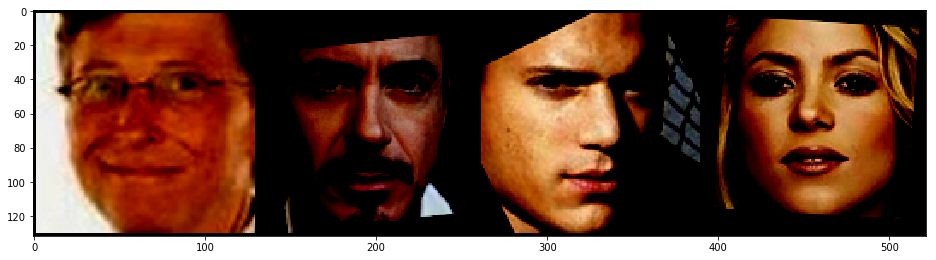

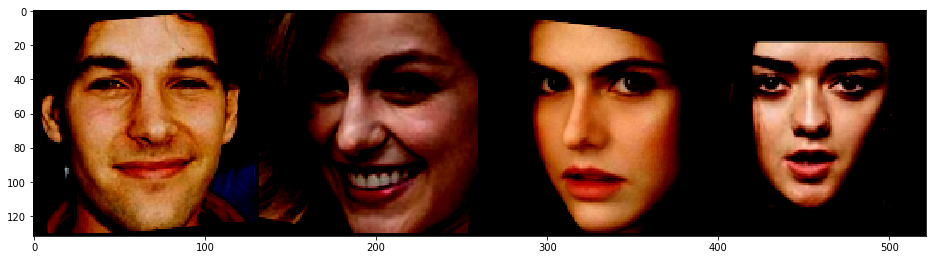

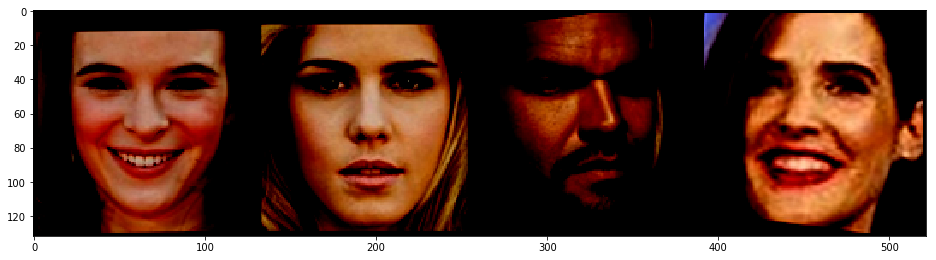

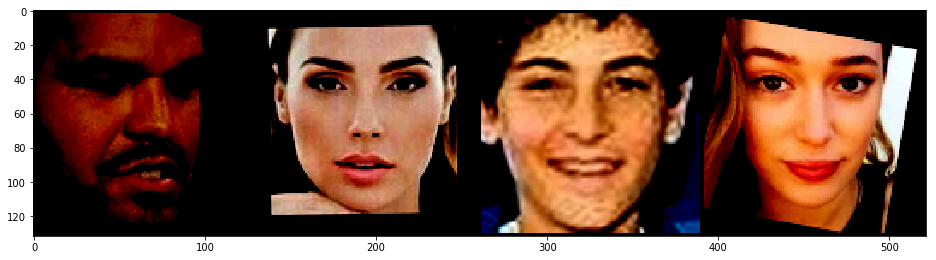

In [6]:
import PIL
%matplotlib inline
import matplotlib.pyplot as plt

import torchvision

# see the dataloader' data and label
for index, (data, label) in enumerate(train_dataloader):
#     display(data.size())
#     image = torchvision.transforms.ToPILImage()(data[0])
#     plt.imshow(image)
#     display(label[0], index2person[label[0].item()])
    img = torchvision.utils.make_grid(data).numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.figure(figsize=(16, 9))
    plt.imshow(img)
    
    if index == 3:
        break

# 2 Model

In [7]:
# baseline is SqueezeNext, 因为要落地，兄弟。
from model.SqueezeNext import SqNxt_23_1x_v5
from model.SqueezeNext import conv_init
import torch.nn.functional as F
import torch.nn as nn
import torch

net = SqNxt_23_1x_v5(1)
net.apply(conv_init)

is_use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_use_cuda else 'cpu')

net = net.to(device)

# 3 Loss

In [8]:
from loss.arcface import ArcMarginProduct
metric = ArcMarginProduct(128, 100, device=device)
metric = metric.to(device)

In [9]:
from loss.focal_loss import FocalLoss_classification
criterion = nn.CrossEntropyLoss()

# 4 Optimization

In [10]:
from optimization.CosineWarmupLr import CosineWarmupLr

In [11]:
import torch.optim as optim

lr = 1e-3
num_epochs = 500
best_acc = 0.

def lr_schedule(lr, epoch):
    optim_factor = 0
    if epoch > 160:
        optim_factor = 3
    elif epoch > 120:
        optim_factor = 2
    elif epoch > 60:
        optim_factor = 1
        
    return lr * math.pow(0.2, optim_factor)

num_cos = 10
optimizer  = optim.SGD(net.parameters(), 
                           lr=lr, 
                           momentum=0.9, 
                           weight_decay=5e-4)
scheduler = CosineWarmupLr(optimizer, batch_size, num_cos, lr, lr*10,
                           warmup_epochs=3, warmup_lr=lr*0.1)

In [12]:
# start_epoch = 1

# lrs = []
# for _epoch in range(start_epoch, start_epoch + num_epochs):
#     scheduler.step()
#     lrs.append(scheduler.learning_rate)
    
# import matplotlib.pyplot as plt
# plt.plot(lrs)

In [13]:
def train(epoch):
    net.train()
    train_loss = 0
    correct    = 0
    total      = 0
    
    print('Training Epoch: #%d, LR: %.4f'%(epoch, scheduler.learning_rate))
    for idx, (inputs, labels) in enumerate(train_dataloader):
        if is_use_cuda:
            inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        features = net(inputs)
        outputs = metric(features, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predict = torch.max(outputs, 1)
        total      += labels.size(0)
        correct    += predict.eq(labels).cpu().sum().double()
        
        sys.stdout.write('\r')
        sys.stdout.write('[%s] Training Epoch [%d/%d] Iter[%d/%d]\t\tLoss: %.4f Acc@1: %.3f'
                        % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                           epoch, num_epochs, idx, len(train_dataset) // batch_size, 
                          train_loss / (batch_size * (idx + 1)), correct / total))
        sys.stdout.flush()

In [14]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct   = 0
    total     = 0
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            if is_use_cuda:
                inputs, labels = inputs.to(device), labels.to(device)
            features = net(inputs)
            outputs = metric(features, labels)
            loss = criterion(outputs, labels)

            test_loss  += loss.item()
            _, predict = torch.max(outputs, 1)
            total      += labels.size(0)
            correct    += predict.eq(labels).cpu().sum().double()

            sys.stdout.write('\r')
            sys.stdout.write('[%s] Testing Epoch [%d/%d] Iter[%d/%d]\t\tLoss: %.4f Acc@1: %.3f'
                            % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                               epoch, num_epochs, idx, len(valid_dataset) // batch_size, 
                              test_loss / (100 * (idx + 1)), correct / total))
            sys.stdout.flush()
        
    if correct / total > best_acc:
        print()
        print('Saving Model...')
        state = {
            'net': net.modules if is_use_cuda else net,
            'acc': correct / total,
            'epoch': epoch
        }
        if not os.path.isdir('./checkpoint/SqNxt_23_1x'):
            os.makedirs('./checkpoint/SqNxt_23_1x')
        torch.save(state, './checkpoint/SqNxt_23_1x/SqNxt_23_1x_Cifar10.ckpt')
        best_acc = correct / total
        print('Best Acc@1: %.4f' % (best_acc * 100))

In [ ]:
import time
import math

start_epoch = 1

lrs = []
for _epoch in range(start_epoch, start_epoch + num_epochs):
    scheduler.step()
#     lrs.append(scheduler.learning_rate)
    start_time = time.time()
    train(_epoch)
    print()
    test(_epoch)
    print()
    print()
    end_time   = time.time()
    print('Epoch #%d Cost %ds' % (_epoch, end_time - start_time))
    
# print('Best Acc@1: %.4f' % (best_acc * 100))

Training Epoch: #1, LR: 0.0003
[2019-11-12 06:30:36] Training Epoch [1/500] Iter[2412/2412]		Loss: 4.9179 Acc@1: 0.000
[2019-11-12 06:30:57] Testing Epoch [1/500] Iter[280/280]		Loss: 0.1977 Acc@1: 0.000

Epoch #1 Cost 537s
Training Epoch: #2, LR: 0.0003
[2019-11-12 06:39:40] Training Epoch [2/500] Iter[2412/2412]		Loss: 4.7956 Acc@1: 0.000
[2019-11-12 06:40:01] Testing Epoch [2/500] Iter[280/280]		Loss: 0.1948 Acc@1: 0.000

Epoch #2 Cost 544s
Training Epoch: #3, LR: 0.0004
[2019-11-12 06:48:41] Training Epoch [3/500] Iter[2412/2412]		Loss: 4.7640 Acc@1: 0.000
[2019-11-12 06:49:02] Testing Epoch [3/500] Iter[280/280]		Loss: 0.1950 Acc@1: 0.000

Epoch #3 Cost 541s
Training Epoch: #4, LR: 0.0005
[2019-11-12 06:57:45] Training Epoch [4/500] Iter[2412/2412]		Loss: 4.7487 Acc@1: 0.000
[2019-11-12 06:58:06] Testing Epoch [4/500] Iter[280/280]		Loss: 0.1947 Acc@1: 0.000

Epoch #4 Cost 543s
Training Epoch: #5, LR: 0.0006
[2019-11-12 07:06:51] Training Epoch [5/500] Iter[2412/2412]		Loss: 4.734

[2019-11-12 11:34:41] Training Epoch [37/500] Iter[2412/2412]		Loss: 4.0667 Acc@1: 0.002
[2019-11-12 11:35:00] Testing Epoch [37/500] Iter[280/280]		Loss: 0.1982 Acc@1: 0.000

Epoch #37 Cost 487s
Training Epoch: #38, LR: 0.0100
[2019-11-12 11:42:49] Training Epoch [38/500] Iter[2412/2412]		Loss: 4.0322 Acc@1: 0.002
[2019-11-12 11:43:08] Testing Epoch [38/500] Iter[280/280]		Loss: 0.1774 Acc@1: 0.000

Epoch #38 Cost 488s
Training Epoch: #39, LR: 0.0100
[2019-11-12 11:51:00] Training Epoch [39/500] Iter[2412/2412]		Loss: 4.0001 Acc@1: 0.004
[2019-11-12 11:51:20] Testing Epoch [39/500] Iter[280/280]		Loss: 0.1934 Acc@1: 0.000

Epoch #39 Cost 491s
Training Epoch: #40, LR: 0.0100
[2019-11-12 11:59:11] Training Epoch [40/500] Iter[2412/2412]		Loss: 3.9556 Acc@1: 0.005
[2019-11-12 11:59:31] Testing Epoch [40/500] Iter[280/280]		Loss: 0.1842 Acc@1: 0.000

Epoch #40 Cost 490s
Training Epoch: #41, LR: 0.0099
[2019-11-12 12:07:23] Training Epoch [41/500] Iter[2412/2412]		Loss: 3.9185 Acc@1: 0.005

[2019-11-12 16:34:46] Training Epoch [71/500] Iter[2412/2412]		Loss: 1.9840 Acc@1: 0.217
[2019-11-12 16:35:05] Testing Epoch [71/500] Iter[280/280]		Loss: 0.1629 Acc@1: 0.051

Epoch #71 Cost 508s
Training Epoch: #72, LR: 0.0017
[2019-11-12 16:43:02] Training Epoch [72/500] Iter[2412/2412]		Loss: 2.1891 Acc@1: 0.189
[2019-11-12 16:43:22] Testing Epoch [72/500] Iter[280/280]		Loss: 0.1581 Acc@1: 0.055

Epoch #72 Cost 496s
Training Epoch: #73, LR: 0.0020
[2019-11-12 16:51:19] Training Epoch [73/500] Iter[2412/2412]		Loss: 2.3497 Acc@1: 0.162
[2019-11-12 16:51:39] Testing Epoch [73/500] Iter[280/280]		Loss: 0.1749 Acc@1: 0.035

Epoch #73 Cost 496s
Training Epoch: #74, LR: 0.0023
[2019-11-12 16:59:35] Training Epoch [74/500] Iter[2412/2412]		Loss: 2.5257 Acc@1: 0.132
[2019-11-12 16:59:54] Testing Epoch [74/500] Iter[280/280]		Loss: 0.1733 Acc@1: 0.023

Epoch #74 Cost 495s
Training Epoch: #75, LR: 0.0027
[2019-11-12 17:07:52] Training Epoch [75/500] Iter[2412/2412]		Loss: 2.6212 Acc@1: 0.120

[2019-11-12 21:35:34] Training Epoch [107/500] Iter[2412/2412]		Loss: 2.8535 Acc@1: 0.130
[2019-11-12 21:35:54] Testing Epoch [107/500] Iter[280/280]		Loss: 0.1610 Acc@1: 0.050

Epoch #107 Cost 495s
Training Epoch: #108, LR: 0.0060
[2019-11-12 21:43:48] Training Epoch [108/500] Iter[2412/2412]		Loss: 2.7420 Acc@1: 0.148
[2019-11-12 21:44:07] Testing Epoch [108/500] Iter[280/280]		Loss: 0.1628 Acc@1: 0.049

Epoch #108 Cost 493s
Training Epoch: #109, LR: 0.0055
[2019-11-12 21:51:59] Training Epoch [109/500] Iter[2412/2412]		Loss: 2.6574 Acc@1: 0.162
[2019-11-12 21:52:19] Testing Epoch [109/500] Iter[280/280]		Loss: 0.1610 Acc@1: 0.052

Epoch #109 Cost 491s
Training Epoch: #110, LR: 0.0050
[2019-11-12 22:00:14] Training Epoch [110/500] Iter[2412/2412]		Loss: 2.5118 Acc@1: 0.193
[2019-11-12 22:00:34] Testing Epoch [110/500] Iter[280/280]		Loss: 0.1659 Acc@1: 0.045

Epoch #110 Cost 494s
Training Epoch: #111, LR: 0.0045
[2019-11-12 22:08:28] Training Epoch [111/500] Iter[2412/2412]		Loss: 2.

[2019-11-13 02:23:07] Testing Epoch [141/500] Iter[280/280]		Loss: 0.1827 Acc@1: 0.012

Epoch #141 Cost 508s
Training Epoch: #142, LR: 0.0079
[2019-11-13 02:31:02] Training Epoch [142/500] Iter[2412/2412]		Loss: 3.0658 Acc@1: 0.079
[2019-11-13 02:31:21] Testing Epoch [142/500] Iter[280/280]		Loss: 0.2078 Acc@1: 0.003

Epoch #142 Cost 494s
Training Epoch: #143, LR: 0.0083
[2019-11-13 02:39:17] Training Epoch [143/500] Iter[2412/2412]		Loss: 3.1313 Acc@1: 0.078
[2019-11-13 02:39:36] Testing Epoch [143/500] Iter[280/280]		Loss: 0.1881 Acc@1: 0.003

Epoch #143 Cost 495s
Training Epoch: #144, LR: 0.0087
[2019-11-13 02:47:32] Training Epoch [144/500] Iter[2412/2412]		Loss: 3.1472 Acc@1: 0.067
[2019-11-13 02:47:51] Testing Epoch [144/500] Iter[280/280]		Loss: 0.1945 Acc@1: 0.015

Epoch #144 Cost 495s
Training Epoch: #145, LR: 0.0090
[2019-11-13 02:55:46] Training Epoch [145/500] Iter[2412/2412]		Loss: 3.2217 Acc@1: 0.065
[2019-11-13 02:56:05] Testing Epoch [145/500] Iter[280/280]		Loss: 0.175

[2019-11-13 07:13:28] Testing Epoch [176/500] Iter[280/280]		Loss: 0.1299 Acc@1: 0.178

Epoch #176 Cost 504s
Training Epoch: #177, LR: 0.0011
[2019-11-13 07:21:19] Training Epoch [177/500] Iter[2412/2412]		Loss: 1.2750 Acc@1: 0.452
[2019-11-13 07:21:39] Testing Epoch [177/500] Iter[280/280]		Loss: 0.1443 Acc@1: 0.153

Epoch #177 Cost 490s
Training Epoch: #178, LR: 0.0010
[2019-11-13 07:29:29] Training Epoch [178/500] Iter[2412/2412]		Loss: 1.2073 Acc@1: 0.474
[2019-11-13 07:29:49] Testing Epoch [178/500] Iter[280/280]		Loss: 0.1192 Acc@1: 0.219

Epoch #178 Cost 490s
Training Epoch: #179, LR: 0.0010
[2019-11-13 07:37:41] Training Epoch [179/500] Iter[2412/2412]		Loss: 1.1923 Acc@1: 0.471
[2019-11-13 07:38:01] Testing Epoch [179/500] Iter[280/280]		Loss: 0.1241 Acc@1: 0.202

Epoch #179 Cost 491s
Training Epoch: #180, LR: 0.0010
[2019-11-13 07:45:49] Training Epoch [180/500] Iter[2412/2412]		Loss: 1.1610 Acc@1: 0.474
[2019-11-13 07:46:09] Testing Epoch [180/500] Iter[280/280]		Loss: 0.127

[2019-11-13 12:04:20] Testing Epoch [211/500] Iter[280/280]		Loss: 0.1754 Acc@1: 0.005

Epoch #211 Cost 505s
Training Epoch: #212, LR: 0.0093
[2019-11-13 12:12:13] Training Epoch [212/500] Iter[2412/2412]		Loss: 3.1524 Acc@1: 0.033
[2019-11-13 12:12:32] Testing Epoch [212/500] Iter[280/280]		Loss: 0.1924 Acc@1: 0.002

Epoch #212 Cost 491s
Training Epoch: #213, LR: 0.0090
[2019-11-13 12:20:21] Training Epoch [213/500] Iter[2412/2412]		Loss: 3.1252 Acc@1: 0.032
[2019-11-13 12:20:40] Testing Epoch [213/500] Iter[280/280]		Loss: 0.1813 Acc@1: 0.001

Epoch #213 Cost 488s
Training Epoch: #214, LR: 0.0087
[2019-11-13 12:28:32] Training Epoch [214/500] Iter[2412/2412]		Loss: 3.1462 Acc@1: 0.033
[2019-11-13 12:28:52] Testing Epoch [214/500] Iter[280/280]		Loss: 0.1585 Acc@1: 0.012

Epoch #214 Cost 491s
Training Epoch: #215, LR: 0.0083
[2019-11-13 12:36:43] Training Epoch [215/500] Iter[2412/2412]		Loss: 3.0549 Acc@1: 0.038
[2019-11-13 12:37:03] Testing Epoch [215/500] Iter[280/280]		Loss: 0.171

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)